## Nbdev import session

In [1]:
#default_exp kernel

In [2]:
#hide
from nbdev.showdoc import *

#%load_ext autoreload
#%autoreload 2

import sys
sys.path.insert(0, '..') #appends project root to path in order to import project packages since `noteboks_dev` is not on the root


# Code

In [3]:
#export
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import normalize, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD

from scipy import sparse
import numpy as np

from heartwood.neighbors import 

In [4]:
#session of variables to testing sessions
n_features = 7
cardinality_per_feature = 1000
n_classes = 5
n_reg_dims = 2


X = np.random.randint(0,cardinality_per_feature,(1000,n_features))

y_class = np.random.randint(0,n_classes, 1000)
y_reg = np.random.randn(1000,n_reg_dims)

In [14]:
#export
class EstimatorKernel(BaseEstimator, TransformerMixin):    
    '''
    creates a kernel with some specified estimator.
    projection method will be performed according to projection_method.
    projection method can be a string refering to estimators method used to project,
    or a callable, that receives the estimator and X (vector to be projected) as the inputs.
    should return the projections of X according to estimator.
    norm will normalize vectors in matrices prior to applying dot products.
    '''
    def __init__(self, estimator, projection_method = 'predict_proba', norm = 'l2'):
        '''
        creates a kernel with some specified estimator.
        projection method will be performed according to projection_method.
        projection method can be a string refering to estimators method used to project,
        or a callable, that receives the estimator and X (vector to be projected) as the inputs.
        should return the projections of X according to estimator.
        norm will normalize vectors in matrices prior to applying dot products.
        '''
        self.estimator = estimator
        self.projection_method = projection_method
        self.norm = norm
    
    def __getattr__(self, attr):
        '''
        Allows accessing self.estimator attributes if not found in first object level
        '''
        return getattr(self.estimator, attr)
    
    def transform(self, X):
        '''
        projects X into new space, according to projection_method
        '''
        if callable(self.projection_method):
            return self.projection_method(self.estimator, X)
        else:
            return getattr(self.estimator, self.projection_method)(X)            
    
    def fit(self, X, y = None, save_values = None, **kwargs):
        '''
        X is the feature space,
        y is used only for supervised Kernels
        save_values are values associated with each "Embeding". During transform,
        the values of saved_values are retrieved according to indexes returned by Nearest Neighbor query        
        '''
        if not save_values is None:
            if not len(save_values) == len(X):
                raise IndexError(f'X and save_values must have the same shape along the first dimension. Got {X.shape} and {save_values.shape}')
        
        self.estimator.fit(X, y, **kwargs)
        
        self.train_projection_space_ = self.transform(X) #saves projection space of X in train
        self.train_projection_values_ = save_values #saves values to be retrieved by some query
        return self
        
    def similarity_matrix(self, A = None, B = None,  topn = 30, remove_diagonal = False, lower_bound = 0.0, metric = 'cosine', alpha = None):
        '''
        reeturns pariwise_similarity of X and self.train_projection_space_
        if X is None, returns pariwise similarity of self.train_projection_space_ with itself
        '''
        
        METRICS = {
            'cosine':cosine_similarity,            
        }
        
        
        if A is None:
            A = self.train_projection_space_
        else:
            #transform to space
            A = self.transform(A)
        
        if B is None:
            B = self.train_projection_space_
        else:
            #transform to space
            B = self.transform(B)
        
        try:
            sim_matrix = METRICS[metric.lower()](
                #normalize first
                normalize(A, norm = self.norm, axis = 0),
                normalize(B, norm = self.norm, axis = 0),
                topn,
                remove_diagonal,
                lower_bound = lower_bound
            )
            
            #apply alpha concentration factor
            if not alpha is None:
                sim_matrix.data = sim_matrix.data**alpha
            
            return sim_matrix
        
        except KeyError:
            raise AttributeError(f'metric should be one of {list(METRICS)}, got {metric}')
            
    def similarity_idxs(self, A = None, B = None, topn = 30, remove_diagonal = False, lower_bound = 0.0, alpha = None, metric = 'cosine'):
        '''
        performs dot product based similarity of normalized X versus normalized self.train_projection_space_.
        if X is None, returns similarity of self.train_projection_space_ within itself
        
        returns two lists, one of indexes and other of scores, the indexes refer to self.train_projecetion_space_ rows
        
        alpha is a concentration factor, such that similarity_values = similarity_values**alpha
        alpha > 1 implies spreading points appart
        0 < alpha < 1 implies bringing points closer together
        '''        
            
        sim_matrix = self.similarity_matrix(A, B, topn, remove_diagonal, lower_bound, metric, alpha)
        idxs, sim = sim_matrix_to_idx_and_score(sim_matrix)
                
        return idxs, sim
    
    def similarity(self, A = None, B = None, topn = 30, remove_diagonal = False, lower_bound = 0.0, alpha = None, metric = 'cosine'):
        '''
        same as similarity, but instead of returning indexes, returns values in self.train_projection_values_
        '''
        idxs, sim = self.similarity_idxs(A, B, topn, remove_diagonal, lower_bound, alpha, metric)
        values = [self.train_projection_values_[idx] for idx in idxs]
        return values, sim
    
    def update_space(self, X, save_values):
        '''
        updates self.train_projection_space_ and self.train_projection_values_ with new data.
        new values are found running self.transform on X
        '''
        X = self.transform(X)
        
        self.train_projection_space_ = vstack([self.train_projection_space_, X])
        self.train_projection_values_ = vstack([self.train_projection_values_, save_values])
        return self

In [15]:
#export
class SparseForestKernel(EstimatorKernel):
    '''
    A Space tranformation performed based on Forest transformations.
    Can be supervised or not (CARTs, RandomTreeEmbeddings, Boosted trees...)
    
    the embedding_space is sparse and can be defined as the `decision_path` space or `terminal_nodes`
    space.
    '''             
    
    def __init__(self, estimator, embedding_space = 'decision_path'):
        self.embedding_space = embedding_space        
        super().__init__(estimator, projection_method = None, norm='l2')
        return
            
    def transform(self, X):
        
        if self.embedding_space == 'decision_path':
            
            X, n_nodes_ptr = self.estimator.decision_path(X)
            
        elif self.embedding_space == 'terminal_nodes':
            
            if hasattr(self, 'one_hot_node_embeddings_encoder_'):
                X = self.estimator.apply(X)
                X = self.one_hot_node_embeddings_encoder_.transform(X)

            else:
                X = self.estimator.apply(X)
                self.one_hot_node_embeddings_encoder_ = OneHotEncoder().fit(X)
                X = self.one_hot_node_embeddings_encoder_.transform(X)
                
        else:
            raise ValueError(f'embedding_space should be one of ["decision_path","terminal_nodes"], got {self.embedding_space}')
            
        return X 

In [16]:
#export
class DenseForestKernel(EstimatorKernel):
    '''
    combines SparseForestTree and a some densifier (LinearBottleneck or CategoricalLinearKernel) to compress sparse 
    representations to a dense one 
    '''
    def __init__(self, forest_estimator, n_components, densifier = 'categorical_linear', embedding_space = 'decision_path'):
        
        self.forest_estimator = forest_estimator
        self.densifier = densifier
        self.n_components = n_components
        self.embedding_space = embedding_space
        return
    
    def _set_full_estimator_pipeline(self, ):        
        
        AVALIBLE_DENSIFIERS = ['categorical_linear','linear_bottleneck','k_means_embeddings']
        
        is_regression = False
        is_classification = False
        is_transformation = False
        
        #check inference type of estimator
        if hasattr(self.forest_estimator, 'predict_proba'):
            is_classification = True
        elif hasattr(self.forest_estimator, 'predict'):
            is_regression = True        
        else:
            is_transformation = True
            
        if isinstance(self.densifier, str):
            if not self.densifier.lower() in AVALIBLE_DENSIFIERS:
                raise ValueError(f'If str, densifier should be one of {AVALIBLE_DENSIFIERS}, got {self.densifier}')
        
        if is_transformation:
            if isinstance(self.densifier, str):
                raise TypeError(f'if forest_estimator is a transformer (not classifier nor regressor), densifier should be an instance of BaseEstimator, not str')
        
        if is_classification:
            if isinstance(self.densifier, str):
                if self.densifier.lower() == 'categorical_linear':
                    self.densifier = CategoricalLinearKernel(
                        SGDClassifier(loss = 'log'), encode = True, n_components=self.n_components
                    )
                elif self.densifier.lower() == 'linear_bottleneck':
                    self.densifier = ClassificationLinearBottleneck(n_components=self.n_components)
                    
            
            
                    
                
            
        
        
                        
        
        
            
    def fit(self, X, save):
        
                
        

SyntaxError: unexpected EOF while parsing (<ipython-input-16-53b5d3ef45a7>, line 62)

In [17]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression, make_blobs
import seaborn as sns
%matplotlib inline

X, y = make_classification(
    n_samples = 10_000,
    n_features = 3,
    n_informative = 3,
    n_redundant = 0,
    #bias = 10,
    #noise = 10,
    n_classes = 3,
    n_clusters_per_class = 2,
    hypercube = True,
)

plt.clf()
blobs, labels = make_blobs(n_samples = 10_000,cluster_std = 3, n_features = 4)
#sns.scatterplot(*blobs.T, hue = labels)
#plt.show()

<Figure size 432x288 with 0 Axes>

C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


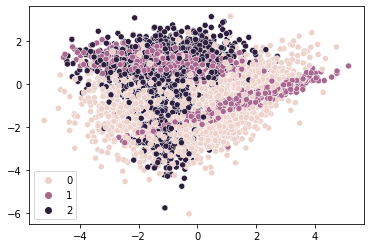

In [18]:
import matplotlib.pyplot as plt
plt.clf()
sns.scatterplot(*X.T[:2], hue = y)
plt.show()

In [19]:
topn = 50
es1 = 'decision_path'
es2 = 'terminal_nodes'
alpha1 = 1.1
alpha2 = 0.9

In [20]:
kernel1 = SparseForestKernel(RandomForestClassifier(100,min_samples_leaf = 10, random_state = 42, n_jobs = -1), embedding_space = es1)
kernel2 = SparseForestKernel(RandomForestClassifier(100,random_state = 42, min_samples_leaf = 10, n_jobs = -1), embedding_space = es2)

kernel1.fit(X, y)
kernel2.fit(X, y)

SparseForestKernel(embedding_space='terminal_nodes',
                   estimator=RandomForestClassifier(min_samples_leaf=10,
                                                    n_jobs=-1,
                                                    random_state=42))

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:888: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  f"MiniBatchKMeans is known to have a memory leak on "
C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


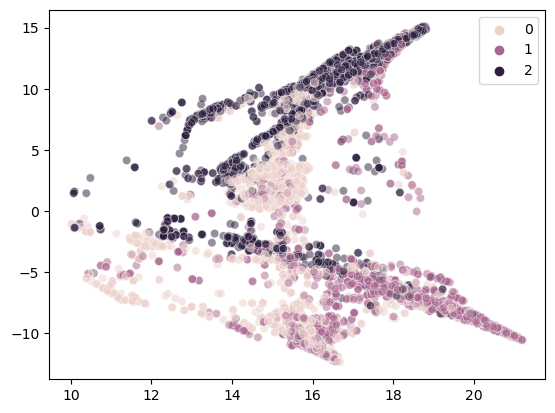

In [23]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA, TruncatedSVD

sample_idxs = np.random.choice(np.arange(len(X)), 10000)

clstr = MiniBatchKMeans(2).fit(X)
tree_embeddings = kernel1.transform(X[sample_idxs])
#pivot_embeddings = clstr.transform(X[sample_idxs])
#pivot_embeddings = PCA(2).fit_transform(pivot_embeddings)
pivot_embeddings = TruncatedSVD(2).fit_transform(tree_embeddings)

sns.scatterplot(*pivot_embeddings.T[:2], hue = y[sample_idxs], alpha = 0.5)
plt.show()

C:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:888: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  f"MiniBatchKMeans is known to have a memory leak on "
C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


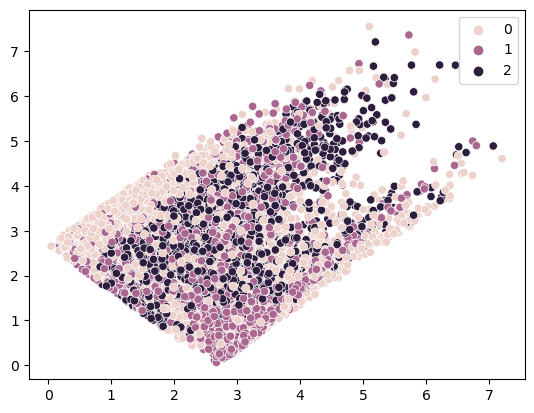

In [24]:
plt.clf()
sns.scatterplot(*MiniBatchKMeans(2).fit_transform(X).T[:2], hue = y)
plt.show()

In [27]:

_, sims1 = kernel1.similarity_idxs(X, remove_diagonal = True, topn = topn, alpha = alpha1)
_, sims2 = kernel2.similarity_idxs(X, remove_diagonal = True, topn = topn, alpha = alpha2)


C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.


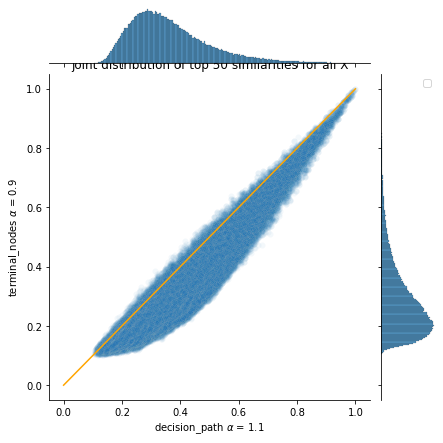

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sims1 = np.stack(sims1).flatten()
sims2 = np.stack(sims2).flatten()

#sns.distplot(dp_sims, label = fr'{es1} $\alpha$ = {alpha1}')
#sns.distplot(tn_sims, label = fr'{es2} $\alpha$ = {alpha2}')
plot = sns.jointplot(sims1, sims2, joint_kws = dict(alpha = 0.05))
plot.ax_joint.set_title(f'joint distribution of top {topn} similarities for all X')
plot.ax_joint.set_xlabel(fr'{es1} $\alpha$ = {alpha1}')
plot.ax_joint.set_ylabel(fr'{es2} $\alpha$ = {alpha2}')
plot.ax_joint.plot([0,1], [0,1], color = 'orange')
plt.legend()

points are closer to each other in decision_path space rather than in temrinal_nodes sapce

In [15]:
decision, ptr = RandomTreesEmbedding().fit(X).decision_path(X)

In [16]:
#export
class CategoricalLinearKernel(EstimatorKernel):    
    '''
    Linear model kernel recommended for high cardinality one hot encoded categorical variables.
    kernel space is defined by liner model coefficients indexed by the nonzero elements
    of X
    
    If encode is set to true, a customized onehotencoder will encode the categorical input.
    
    This kernel will only work if the output of the one hot encoded vectors  have always the same number
    of nonzero elements (equal to the number of categorical features). Thus, its recomended to use the default
    encoder, because it asserts this condition is met during one hot encoding
    '''
    def __init__(self, estimator, norm = 'l2', encode = False, n_components = None, **pcakwargs):
        self.encode = encode
        self.n_components = n_components
        self.pcakwargs = pcakwargs
        super().__init__(estimator, norm)
        return    
    
    def fit(self, X, y = None, save_values = None, **kwargs):
        
        if self.encode:            
            if not self.n_components is None:
                self.estimator = make_pipeline(RobustEncoder(), self.estiamtor, PCA(self.n_components, **self.pcakwargs))
            else:
                self.estimator = make_pipeline(RobustEncoder(), self.estimator)
        else:
            if not self.n_components is None:
                self.estimator = make_pipeline(self.estiamtor, PCA(self.n_components, **self.pcakwargs))
            else:
                pass
                                
        return super().fit(X, y, save_values, **kwargs)
    
    def transform(self, X):
        '''
        multiplies sparse vector to its coef_ s from linear model.
        if multiclass classification, the number of final features will be
        n*original_n_features_before_one_hot_encoding
        '''
        
        if self.encode:
            coefs = self.estimator[-1].coef_
            X = self.estimator[0].transform(X)
        else:            
            coefs = self.estimator.coef_
        
        #create attr if it does now exist yet:
        #this line is supposed to run only during fit call
        if not hasattr(self,'dim_embeddings_'):
            self.dim_embeddings_ = len(X[0].data)
                
        if len(coefs.shape) == 1:
            coefs = coefs.reshape(1,-1)
        
        embeddings = []
        for dim in range(coefs.shape[0]):
            #assumes all rows have the same ammount of nonzero elements
            dim_embeddings = coefs[dim, X.nonzero()[1]].reshape(X.shape[0], self.dim_embeddings_)
            embeddings.append(dim_embeddings)                    
                
        return hstack(embeddings)
    

In [28]:
#export
class ClassificationLinearBottleneck(MLPClassifier):
    '''
    Linear boottleneck of a classification task, usefull for dimensionality reduction
    or densification of sparse representations.
    '''
    def __init__(
        self,
        n_components = 2,        
        solver='adam',
        alpha=0.0001,
        batch_size='auto',
        learning_rate='constant',
        learning_rate_init=0.001,
        power_t=0.5,
        max_iter=200,
        shuffle=True,
        random_state=None,
        tol=0.0001,
        verbose=False,
        warm_start=False,
        momentum=0.9,
        nesterovs_momentum=True,
        early_stopping=False,
        validation_fraction=0.1,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        n_iter_no_change=10,
        max_fun=15000,
    ):
        
        #set attributes, some will be overriden in super().__init__ call        
        self.solver = solver
        self.alpha = alpha
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.learning_rate_init = learning_rate_init
        self.power_t = power_t
        self.max_iter = max_iter
        self.shuffle = shuffle
        self.random_state = random_state
        self.tol = tol
        self.verbose = verbose
        self.warm_start = warm_start
        self.momentum = momentum
        self.nesterovs_momentum = nesterovs_momentum
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.n_iter_no_change = n_iter_no_change
        self.max_fun = max_fun
                        
        super().__init__(hidden_layer_sizes = (n_components,), activation = 'identity', **self.__dict__)
        self.n_components = n_components
        return
    
    def transform(self, X, **kwargs):
        '''
        projects inputs to have size (n_samples, n_components)
        '''        
        return _get_sklearn_mlp_activations(self, X)
        

class RegressionLinearBottleneck(MLPRegressor):
    '''
    Linear boottleneck of a classification task, usefull for dimensionality reduction
    or densification of sparse representations.
    '''
    def __init__(
        self,
        n_components = 2,        
        solver='adam',
        alpha=0.0001,
        batch_size='auto',
        learning_rate='constant',
        learning_rate_init=0.001,
        power_t=0.5,
        max_iter=200,
        shuffle=True,
        random_state=None,
        tol=0.0001,
        verbose=False,
        warm_start=False,
        momentum=0.9,
        nesterovs_momentum=True,
        early_stopping=False,
        validation_fraction=0.1,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        n_iter_no_change=10,
        max_fun=15000,
    ):
        
        #set attributes, some will be overriden in super().__init__ call        
        self.solver = solver
        self.alpha = alpha
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.learning_rate_init = learning_rate_init
        self.power_t = power_t
        self.max_iter = max_iter
        self.shuffle = shuffle
        self.random_state = random_state
        self.tol = tol
        self.verbose = verbose
        self.warm_start = warm_start
        self.momentum = momentum
        self.nesterovs_momentum = nesterovs_momentum
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.n_iter_no_change = n_iter_no_change
        self.max_fun = max_fun
                        
        super().__init__(hidden_layer_sizes = (n_components,), activation = 'identity', **self.__dict__)
        self.n_components = n_components
        return
    
    def transform(self, X, **kwargs):
        '''
        projects inputs to have size (n_samples, n_components)
        '''        
        return _get_sklearn_mlp_activations(self, X)

In [ ]:
#export
def _get_sklearn_mlp_activations(self, X, output_layer = -2):
    hidden_layer_sizes = self.hidden_layer_sizes
    if not hasattr(hidden_layer_sizes, "__iter__"):
        hidden_layer_sizes = [hidden_layer_sizes]
    hidden_layer_sizes = list(hidden_layer_sizes)
    layer_units = [X.shape[1]] + hidden_layer_sizes + \
        [self.n_outputs_]
    activations = [X]
    for i in range(self.n_layers_ - 1):
        activations.append(np.empty((X.shape[0],
                                     layer_units[i + 1])))
    self._forward_pass(activations)
    return activations[output_layer]


class MLPKernel(EstimatorKernel):
    
    '''
    returns the output of last hidden layer (before softmax/linear layer)
    as space projection.
    
    Recomended for dimensionality reduction and Context specific bag of words task
    '''    
    def __init__(self, estimator, output_layer = -2, norm='l2'):
        
        self.projection_method = partial(_get_sklearn_mlp_activations, output_layer = output_layer)
        self.estimator = estimator
        self.output_layer = output_layer
        self.norm = norm
        return
    
    

In [ ]:
#export
class BOWKernel(MLPKernel):
    '''
    `MLPKernel` Alias, intended for Bag Of Words application.
    Generates supervised embeddings (context specific embeddings)
    '''
    pass

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier

kernel_lin = CategoricalLinearKernel(LogisticRegression(), encode = True)
kernel_mlp = MLPKernel(MLPClassifier((10,),))
kernel_lin.fit(X,y_class)
kernel_mlp.fit(X,y_class)

kernel_lin.transform(X).shape, kernel_mlp.transform(X).shape

# Export

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()